## Library

In [1]:
import sys
sys.path.append("../../")

In [2]:
SAVE_PATH = "../storage/demo/cnp_TFM_regression.ckpt"

In [3]:
import numpy as np               
import pandas as pd
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm     # Dynamic progress bars
import glob               # Lets us check if checkpoint files exist
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
tf.logging.set_verbosity(tf.logging.ERROR)  # Suppress depreciation warnings
tf.__version__

'1.15.0'

In [5]:
from neuralprocesses.np.aux import DataProvider
from neuralprocesses.utils.tf_utils import tf_sort_by_col
from neuralprocesses.utils.gp import GaussianProcess
from neuralprocesses.utils.gp import squared_exponential_kernel

from neuralprocesses.np.cnp import ConditionalNeuralProcess

from neuralprocesses.utils.plotting import list_plot
from neuralprocesses.utils.plotting import Color

In [6]:
tf.reset_default_graph()
tf.set_random_seed(2019)
tf.disable_eager_execution()

## Data

In [7]:
data = pd.read_csv('^DJI.csv', sep=",")
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index(['Date'])
data['X'] = np.arange(len(data))
data

,Open,High,Low,Close,Adj Close,Volume,X
Date,,,,,,,
1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000,0
1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,1
1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,2
1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,3
1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000,4
...,...,...,...,...,...,...,...
2020-02-21,29146.529297,29146.529297,28892.699219,28992.410156,28992.410156,311210000,8837
2020-02-24,28402.929688,28402.929688,27912.439453,27960.800781,27960.800781,452580000,8838
2020-02-25,28037.650391,28149.199219,26997.619141,27081.359375,27081.359375,513270000,8839


## Data Preprocessing

In [8]:
data_train = pd.DataFrame(data[['Adj Close','X']].values, columns=['T','X']).loc[:500]
data_test_1 = pd.DataFrame(data[['Adj Close','X']].values, columns=['T','X']).loc[500:1000]
data_test_2 = pd.DataFrame(data[['Adj Close','X']].values, columns=['T','X']).loc[1000:1500]
data_test_3 = pd.DataFrame(data[['Adj Close','X']].values, columns=['T','X']).loc[1500:2000]
data_test_4 = pd.DataFrame(data[['Adj Close','X']].values, columns=['T','X']).loc[2000:2500]
data_test_5 = pd.DataFrame(data[['Adj Close','X']].values, columns=['T','X']).loc[2500:3000]
data_test_6 = pd.DataFrame(data[['Adj Close','X']].values, columns=['T','X']).loc[3000:3500]
data_test_7 = pd.DataFrame(data[['Adj Close','X']].values, columns=['T','X']).loc[3500:4000]

for s in range(1,2):
    data_train['Y'.format(s)] = data_train['T'].shift(s)
    data_test_1['Y'.format(s)] = data_test_1['T'].shift(s)
    data_test_2['Y'.format(s)] = data_test_2['T'].shift(s)
    data_test_3['Y'.format(s)] = data_test_3['T'].shift(s)
    data_test_4['Y'.format(s)] = data_test_4['T'].shift(s)
    data_test_5['Y'.format(s)] = data_test_5['T'].shift(s)
    data_test_6['Y'.format(s)] = data_test_6['T'].shift(s)
    data_test_7['Y'.format(s)] = data_test_7['T'].shift(s)

data_train = data_train.dropna()
data_test_1 = data_test_1.dropna()
data_test_2 = data_test_2.dropna()
data_test_3 = data_test_3.dropna()
data_test_4 = data_test_4.dropna()
data_test_5 = data_test_5.dropna()
data_test_6 = data_test_6.dropna()
data_test_7 = data_test_7.dropna()
X_train = data_train.drop(['X','T'], axis=1)
y_train = data_train.drop(['X','Y'], axis=1)
X_test_1 = data_test_1.drop(['X','T'], axis=1)
y_test_1 = data_test_1.drop(['X','Y'], axis=1)
X_test_2 = data_test_2.drop(['X','T'], axis=1)
y_test_2 = data_test_2.drop(['X','Y'], axis=1)
X_test_3 = data_test_3.drop(['X','T'], axis=1)
y_test_3 = data_test_3.drop(['X','Y'], axis=1)
X_test_4 = data_test_4.drop(['X','T'], axis=1)
y_test_4 = data_test_4.drop(['X','Y'], axis=1)
X_test_5 = data_test_5.drop(['X','T'], axis=1)
y_test_5 = data_test_5.drop(['X','Y'], axis=1)
X_test_6 = data_test_6.drop(['X','T'], axis=1)
y_test_6 = data_test_6.drop(['X','Y'], axis=1)
X_test_7 = data_test_7.drop(['X','T'], axis=1)
y_test_7 = data_test_7.drop(['X','Y'], axis=1)


print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test 1 size: (%d x %d)'%(y_test_1.shape[0], y_test_1.shape[1]))
print('Test 2 size: (%d x %d)'%(y_test_2.shape[0], y_test_2.shape[1]))
print('Test 3 size: (%d x %d)'%(y_test_3.shape[0], y_test_3.shape[1]))
print('Test 4 size: (%d x %d)'%(y_test_4.shape[0], y_test_4.shape[1]))
print('Test 5 size: (%d x %d)'%(y_test_5.shape[0], y_test_5.shape[1]))
print('Test 6 size: (%d x %d)'%(y_test_6.shape[0], y_test_6.shape[1]))
print('Test 7 size: (%d x %d)'%(y_test_7.shape[0], y_test_7.shape[1]))

Train size: (500 x 1)
Test 1 size: (500 x 1)
Test 2 size: (500 x 1)
Test 3 size: (500 x 1)
Test 4 size: (500 x 1)
Test 5 size: (500 x 1)
Test 6 size: (500 x 1)
Test 7 size: (500 x 1)


## RNN Model

In [9]:
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                            inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)

from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Input, Dense, LSTM
from tensorflow.python.keras.models import Sequential

tf.keras.backend.clear_session()

nn = Sequential()
nn.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
nn.add(Dense(5,input_shape=(X_train.shape[1],), activation="relu"))
nn.add(Dense(5,input_shape=(X_train.shape[1],), activation="relu"))
nn.add(Dense(1))

adam = Adam(lr=0.1, beta_1=0.92, beta_2=0.999, decay=0.0, amsgrad=False)
nn.compile(optimizer=adam, loss='mean_absolute_error')
nn.summary()
history_nn = nn.fit(x=X_train, y=y_train, batch_size=16, epochs=17, verbose=1, callbacks=None)
y_pred_nn_1 = nn.predict(X_test_1)
y_pred_nn_2 = nn.predict(X_test_2)
y_pred_nn_3 = nn.predict(X_test_3)
y_pred_nn_4 = nn.predict(X_test_4)
y_pred_nn_5 = nn.predict(X_test_5)
y_pred_nn_6 = nn.predict(X_test_6)
y_pred_nn_7 = nn.predict(X_test_7)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
Train on 500 samples
Epoch 1/17
500/500 [==============================] - 0s 436us/sample - loss: 777.2935
Epoch 2/17
500/500 [==============================] - 0s 63us/sample - loss: 207.9437
Epoch 3/17
500/500 [==============================] - 0s 65us/

## CNP DATA

In [10]:
def target_split(data, interval):
    target_index_list = list([True if (i+1)%interval==0 else False for i in list(np.arange(0, data.shape[0], 1))])
    context_index_list = list([False if (i+1)%interval==0 else True for i in list(np.arange(0, data.shape[0], 1))])
    target = data.loc[target_index_list]
    context = data.loc[context_index_list]
    return context, target

In [11]:
BATCH_SIZE = 1
plotting_mode = tf.placeholder(dtype=tf.bool, name="plotting_mode")
interval_num = 2
context_cnp, target_cnp = target_split(data_train,interval_num)
context_test_1, target_test_1 = target_split(data_test_1,interval_num)
context_test_2, target_test_2 = target_split(data_test_2,interval_num)
context_test_3, target_test_3 = target_split(data_test_3,interval_num)
context_test_4, target_test_4 = target_split(data_test_4,interval_num)
context_test_5, target_test_5 = target_split(data_test_5,interval_num)
context_test_6, target_test_6 = target_split(data_test_6,interval_num)
context_test_7, target_test_7 = target_split(data_test_7,interval_num)

# Choose the number of context points
num_context_points = tf.random_uniform(
    shape=(),
    minval=tf.dtypes.saturate_cast(context_cnp.shape[0]/BATCH_SIZE, tf.int32, name=None),
    maxval=tf.dtypes.saturate_cast(context_cnp.shape[0]/BATCH_SIZE+1, tf.int32, name=None),
    dtype=tf.int32
)

# Choose the number of target points
num_target_points = tf.random_uniform(
    shape=(),
    minval=tf.dtypes.saturate_cast(target_cnp.shape[0]/BATCH_SIZE, tf.int32, name=None),
    maxval=tf.dtypes.saturate_cast(target_cnp.shape[0]/BATCH_SIZE+1, tf.int32, name=None),
    dtype=tf.int32
)

In [12]:
# Train
x_context = tf.dtypes.saturate_cast(tf.reshape(context_cnp['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context = tf.dtypes.saturate_cast(tf.reshape(context_cnp['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target = tf.dtypes.saturate_cast(tf.reshape(target_cnp['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target = tf.dtypes.saturate_cast(tf.reshape(target_cnp['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 1
x_context_test = tf.dtypes.saturate_cast(tf.reshape(context_test_1['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test = tf.dtypes.saturate_cast(tf.reshape(context_test_1['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test = tf.dtypes.saturate_cast(tf.reshape(target_test_1['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test = tf.dtypes.saturate_cast(tf.reshape(target_test_1['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 2
x_context_test_2 = tf.dtypes.saturate_cast(tf.reshape(context_test_2['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test_2 = tf.dtypes.saturate_cast(tf.reshape(context_test_2['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test_2 = tf.dtypes.saturate_cast(tf.reshape(target_test_2['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test_2 = tf.dtypes.saturate_cast(tf.reshape(target_test_2['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 3
x_context_test_3 = tf.dtypes.saturate_cast(tf.reshape(context_test_3['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test_3 = tf.dtypes.saturate_cast(tf.reshape(context_test_3['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test_3 = tf.dtypes.saturate_cast(tf.reshape(target_test_3['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test_3 = tf.dtypes.saturate_cast(tf.reshape(target_test_3['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 4
x_context_test_4 = tf.dtypes.saturate_cast(tf.reshape(context_test_4['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test_4 = tf.dtypes.saturate_cast(tf.reshape(context_test_4['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test_4 = tf.dtypes.saturate_cast(tf.reshape(target_test_4['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test_4 = tf.dtypes.saturate_cast(tf.reshape(target_test_4['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 5
x_context_test_5 = tf.dtypes.saturate_cast(tf.reshape(context_test_5['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test_5 = tf.dtypes.saturate_cast(tf.reshape(context_test_5['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test_5 = tf.dtypes.saturate_cast(tf.reshape(target_test_5['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test_5 = tf.dtypes.saturate_cast(tf.reshape(target_test_5['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 6
x_context_test_6 = tf.dtypes.saturate_cast(tf.reshape(context_test_6['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test_6 = tf.dtypes.saturate_cast(tf.reshape(context_test_6['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test_6 = tf.dtypes.saturate_cast(tf.reshape(target_test_6['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test_6 = tf.dtypes.saturate_cast(tf.reshape(target_test_6['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 7
x_context_test_7 = tf.dtypes.saturate_cast(tf.reshape(context_test_7['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test_7 = tf.dtypes.saturate_cast(tf.reshape(context_test_7['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test_7 = tf.dtypes.saturate_cast(tf.reshape(target_test_7['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test_7 = tf.dtypes.saturate_cast(tf.reshape(target_test_7['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

In [13]:
import collections
RegressionInput = collections.namedtuple(
    "RegressionInput",
    ("queries", "targets", "num_context", "num_target"))
data = RegressionInput(queries=((x_context, y_context), x_target), targets=y_target, num_context=num_context_points, num_target=num_target_points)

## GP Model

In [14]:
#kernel = lambda x: squared_exponential_kernel(x, 2.0)
gp_model = GaussianProcess(squared_exponential_kernel, name="gp-model")

In [15]:
_, gp_mean, gp_variance, _ = gp_model(((x_context, y_context), x_target))

In [16]:
with tf.variable_scope("gp_plot"):
    gp_plot_context = tf_sort_by_col(tf.stack([x_context[0], y_context[0]], axis=1), 0)
    gp_plot_mean = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0]], axis=1), 0)
    gp_plot_max = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0] + tf.sqrt(gp_variance[0])], axis=1), 0)
    gp_plot_min = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0] - tf.sqrt(gp_variance[0])], axis=1), 0)

## CNP Model

In [17]:
cnp = ConditionalNeuralProcess(name="cnp-model")

In [18]:
cnp_mean, cnp_variance, cnp_loss = cnp(data)

In [19]:
with tf.variable_scope("cnp_trainer"):
    optimizer = tf.train.AdamOptimizer()
    training_step = optimizer.minimize(cnp_loss)

In [20]:
with tf.variable_scope("cnp_plot"):
    cnp_plot_context = tf_sort_by_col(tf.stack([x_context[0], y_context[0]], axis=1), 0)
    cnp_plot_mean = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0]], axis=1), 0)
    cnp_plot_max = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0] + tf.sqrt(cnp_variance[0])], axis=1), 0)
    cnp_plot_min = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0] - tf.sqrt(cnp_variance[0])], axis=1), 0)

### Training

In [21]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [22]:
NUM_EPISODES = 3000
SAVE_STEP = 1000

with tf.Session() as session:
   
    # Initialize variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver( 
        max_to_keep=4, 
        keep_checkpoint_every_n_hours=1
    )
    session.run(init)

    # Do training
    for episode in tqdm(range(NUM_EPISODES)):
        session.run(training_step, feed_dict={plotting_mode: False})

        if episode % SAVE_STEP == 0 or episode == NUM_EPISODES - 1:
            saver.save(session, SAVE_PATH, global_step=episode)

    # Save resulting graph
    print(f"Model saved in: {saver.save(session, SAVE_PATH)}")

100%|██████████| 3000/3000 [00:10<00:00, 286.10it/s]


Model saved in: ../storage/demo/cnp_TFM_regression.ckpt


## Prediction

In [23]:
def gp_predict(xc, yc, xt, ground_truth_data):
    with tf.Session() as session:        
        #xt = list(yt.index)
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        ctxt, xy, xymax, xymin = session.run(
            [gp_plot_context, gp_plot_mean, gp_plot_max, gp_plot_min],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )
        # Plot the result
        list_plot([xy, xymin, xymax, ctxt, ground_truth_data],
              joined=[True,True,True,False], 
              mesh=[False,False,False,True],
              plot_style=[
                  # Mean in gray
                  Color((0.3,0.3,0.3)),  
                  # Confidence interval bounds in blue
                  Color.color_data(n=1),
                  Color.color_data(n=1),
                  # Context points as Red crosses
                  {"Color": Color.color_data(n=0), "Marker": "+", "PointSize": 300},
                  # Ground truth in black
                  Color((0,0,0))
              ],
              axes_label=("x", "y"),
              filling=[[1,2]]
        )
        return xy

In [24]:
def cnp_predict(xc, yc, xt, ground_truth_data):
    with tf.Session() as session:
        saver.restore(session, SAVE_PATH)
        
        #xt = list(yt.index)
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        ctxt, xy, xymax, xymin = session.run(
            [cnp_plot_context, cnp_plot_mean, cnp_plot_max, cnp_plot_min],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )
        # Plot the result
        list_plot([xy, xymin, xymax, ctxt, ground_truth_data],
              joined=[True,True,True,False], 
              mesh=[False,False,False,True],
              plot_style=[
                  # Mean in gray
                  Color((0.3,0.3,0.3)),  
                  # Confidence interval bounds in blue
                  Color.color_data(n=1),
                  Color.color_data(n=1),
                  # Context points as Red crosses
                  {"Color": Color.color_data(n=0), "Marker": "+", "PointSize": 300},
                  # Ground truth in black
                  Color((0,0,0))
              ],
              axes_label=("x", "y"),
              filling=[[1,2]]
        )
        return xy

In [25]:
with tf.Session() as session:
    xc, yc, xt, yt = session.run([
        x_context_test[0], y_context_test[0], x_target_test[0], y_target_test[0]], feed_dict={plotting_mode: True})
    xc_2, yc_2, xt_2, yt_2 = session.run([
        x_context_test_2[0], y_context_test_2[0], x_target_test_2[0], y_target_test_2[0]], feed_dict={plotting_mode: True})
    xc_3, yc_3, xt_3, yt_3 = session.run([
        x_context_test_3[0], y_context_test_3[0], x_target_test_3[0], y_target_test_3[0]], feed_dict={plotting_mode: True})
    xc_4, yc_4, xt_4, yt_4 = session.run([
        x_context_test_4[0], y_context_test_4[0], x_target_test_4[0], y_target_test_4[0]], feed_dict={plotting_mode: True})
    xc_5, yc_5, xt_5, yt_5 = session.run([
        x_context_test_5[0], y_context_test_5[0], x_target_test_5[0], y_target_test_5[0]], feed_dict={plotting_mode: True})
    xc_6, yc_6, xt_6, yt_6 = session.run([
        x_context_test_6[0], y_context_test_6[0], x_target_test_6[0], y_target_test_6[0]], feed_dict={plotting_mode: True})
    xc_7, yc_7, xt_7, yt_7 = session.run([
        x_context_test_7[0], y_context_test_7[0], x_target_test_7[0], y_target_test_7[0]], feed_dict={plotting_mode: True})

# Result

### - RNN

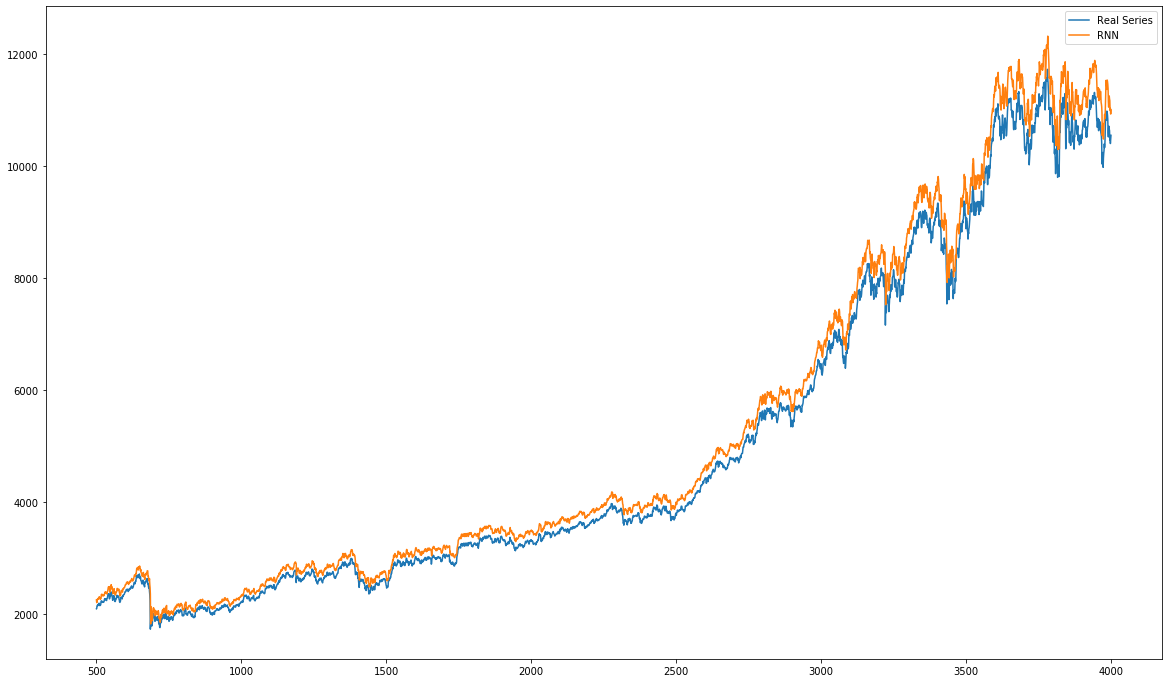

MSE RNN P1:  115.08
MSE RNN P2:  135.62
MSE RNN P3:  159.91
MSE RNN P4:  187.86
MSE RNN P5:  253.50
MSE RNN P6:  398.64
MSE RNN P7:  529.50


In [26]:
y_pred_nn_1=pd.DataFrame(y_pred_nn_1, index=y_test_1.index)
y_pred_nn_2=pd.DataFrame(y_pred_nn_2, index=y_test_2.index)
y_pred_nn_3=pd.DataFrame(y_pred_nn_3, index=y_test_3.index)
y_pred_nn_4=pd.DataFrame(y_pred_nn_4, index=y_test_4.index)
y_pred_nn_5=pd.DataFrame(y_pred_nn_5, index=y_test_5.index)
y_pred_nn_6=pd.DataFrame(y_pred_nn_6, index=y_test_6.index)
y_pred_nn_7=pd.DataFrame(y_pred_nn_7, index=y_test_7.index)
plt.figure(figsize=(20,12))
plt.plot(pd.concat([y_test_1,y_test_2,y_test_3,y_test_4,y_test_5,y_test_6,y_test_7]), label='Real Series')
plt.plot(pd.concat([y_pred_nn_1,y_pred_nn_2,y_pred_nn_3,y_pred_nn_4,y_pred_nn_5,y_pred_nn_6,y_pred_nn_7]), label='RNN')
plt.legend()
plt.show()
print("MSE RNN P1: {0:7.2f}".format((np.absolute(y_test_1 - y_pred_nn_1.values)).values.mean()))
print("MSE RNN P2: {0:7.2f}".format((np.absolute(y_test_2 - y_pred_nn_2.values)).values.mean()))
print("MSE RNN P3: {0:7.2f}".format((np.absolute(y_test_3 - y_pred_nn_3.values)).values.mean()))
print("MSE RNN P4: {0:7.2f}".format((np.absolute(y_test_4 - y_pred_nn_4.values)).values.mean()))
print("MSE RNN P5: {0:7.2f}".format((np.absolute(y_test_5 - y_pred_nn_5.values)).values.mean()))
print("MSE RNN P6: {0:7.2f}".format((np.absolute(y_test_6 - y_pred_nn_6.values)).values.mean()))
print("MSE RNN P7: {0:7.2f}".format((np.absolute(y_test_7 - y_pred_nn_7.values)).values.mean()))

### - GP
#### Part 1

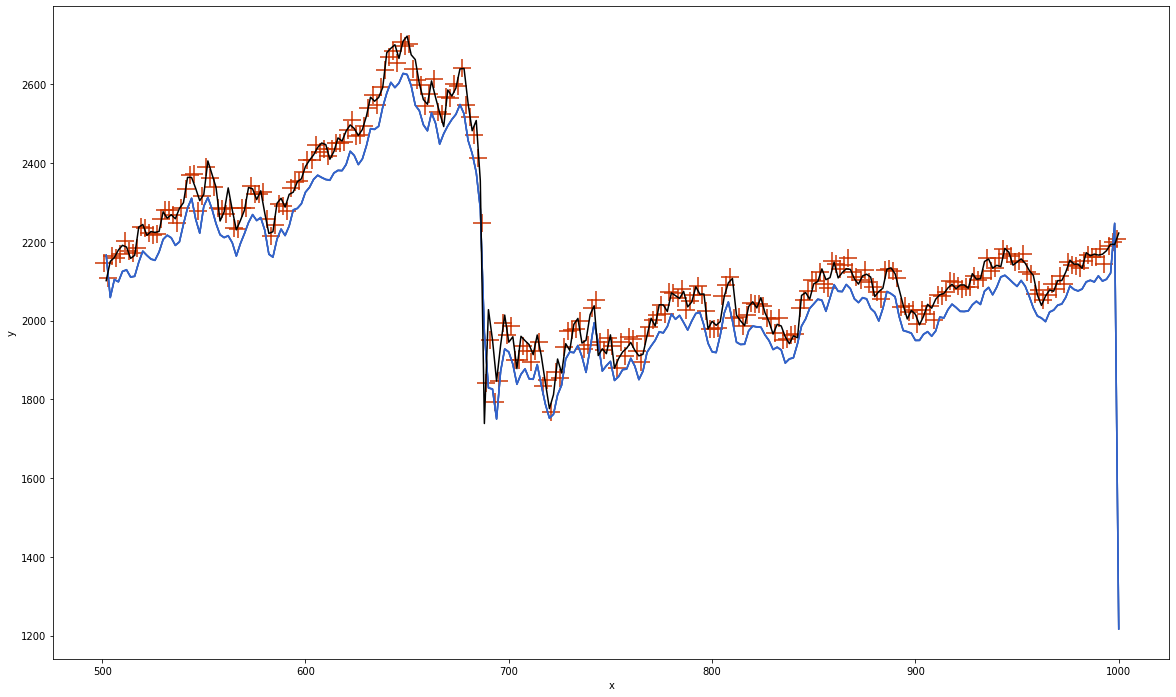

MSE GP:   68.39


In [27]:
plt.figure(figsize=(20,12))
pred_gp = gp_predict(xc, yc, xt, np.transpose([xt, yt]))
print("MSE GP: {0:7.2f}".format((np.absolute(yt - pred_gp[:,1])).mean()))

#### Part 2

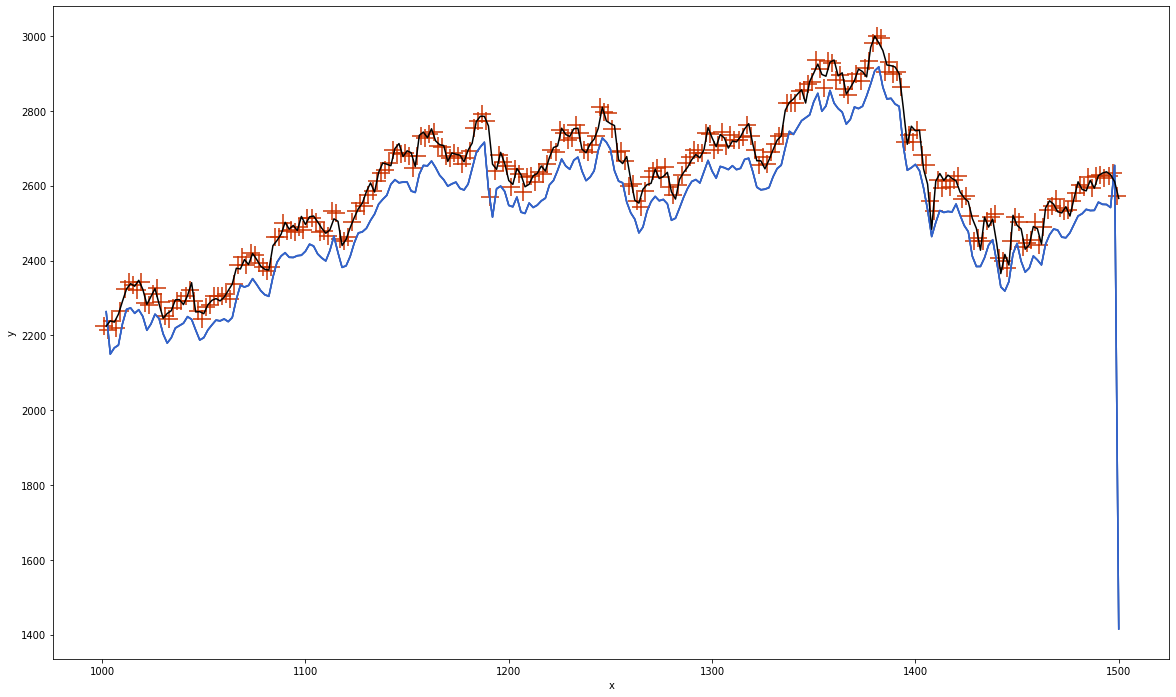

MSE GP:   80.18


In [28]:
plt.figure(figsize=(20,12))
pred_gp_2 = gp_predict(xc_2, yc_2, xt_2, np.transpose([xt_2, yt_2]))
print("MSE GP: {0:7.2f}".format((np.absolute(yt_2 - pred_gp_2[:,1])).mean()))

#### Part 3

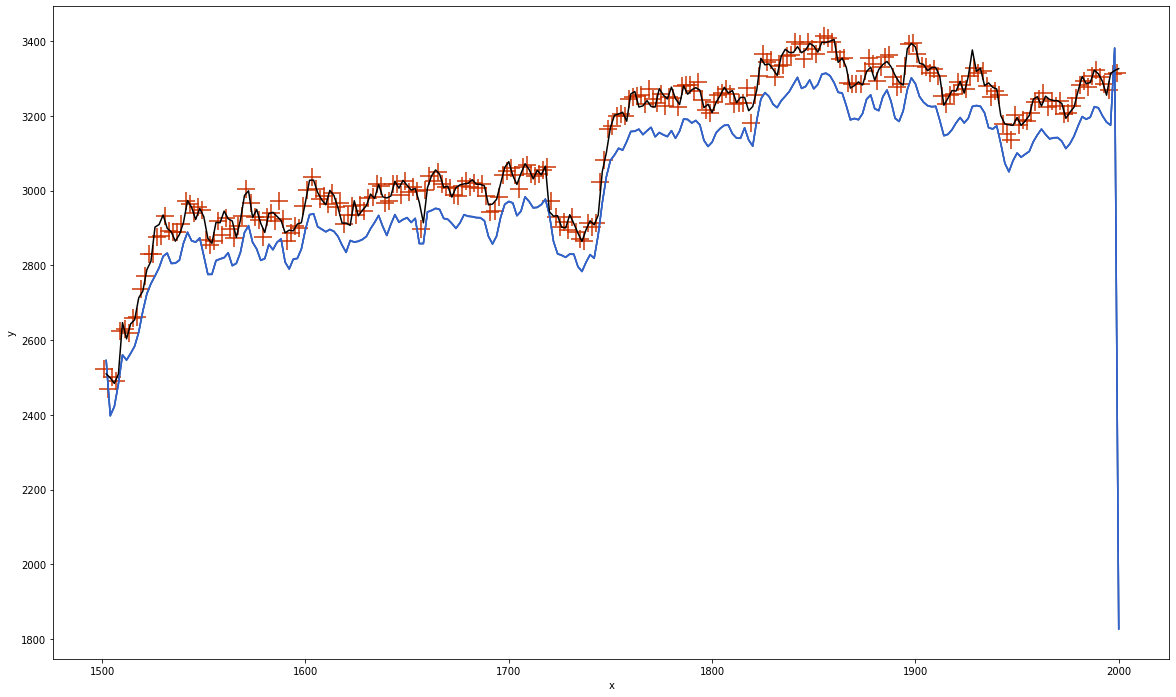

MSE GP:   94.46


In [29]:
plt.figure(figsize=(20,12))
pred_gp_3 = gp_predict(xc_3, yc_3, xt_3, np.transpose([xt_3, yt_3]))
print("MSE GP: {0:7.2f}".format((np.absolute(yt_3 - pred_gp_3[:,1])).mean()))

#### Part 4

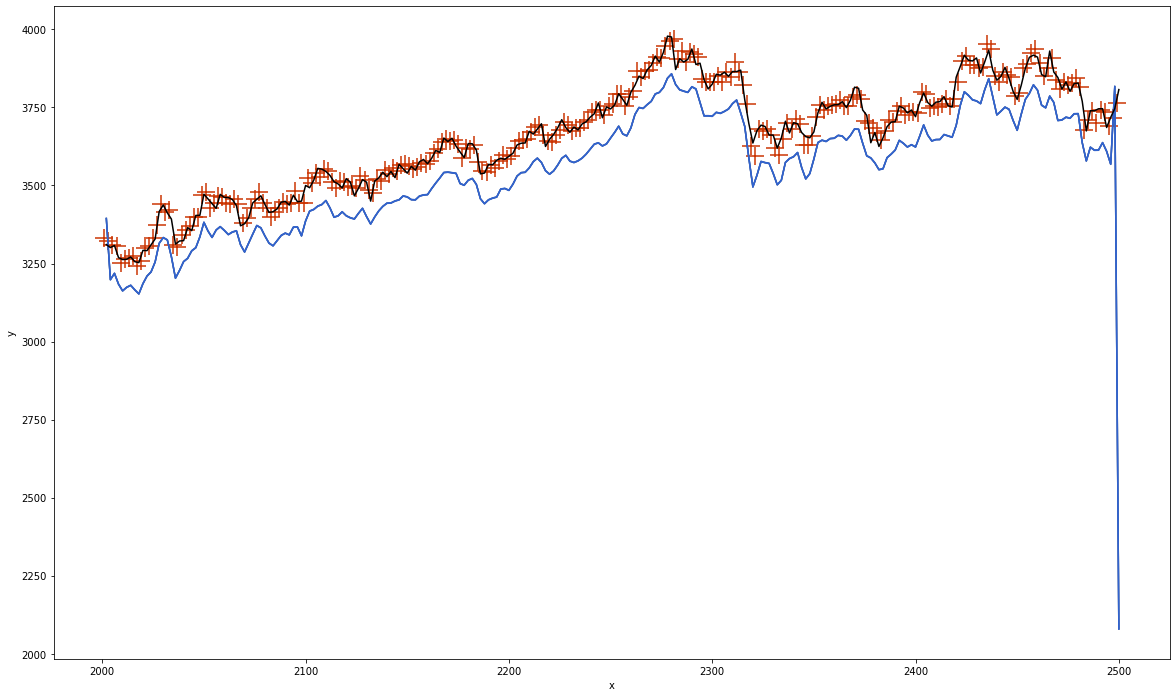

MSE GP:  109.70


In [30]:
plt.figure(figsize=(20,12))
pred_gp_4 = gp_predict(xc_4, yc_4, xt_4, np.transpose([xt_4, yt_4]))
print("MSE GP: {0:7.2f}".format((np.absolute(yt_4 - pred_gp_4[:,1])).mean()))

#### Part 5

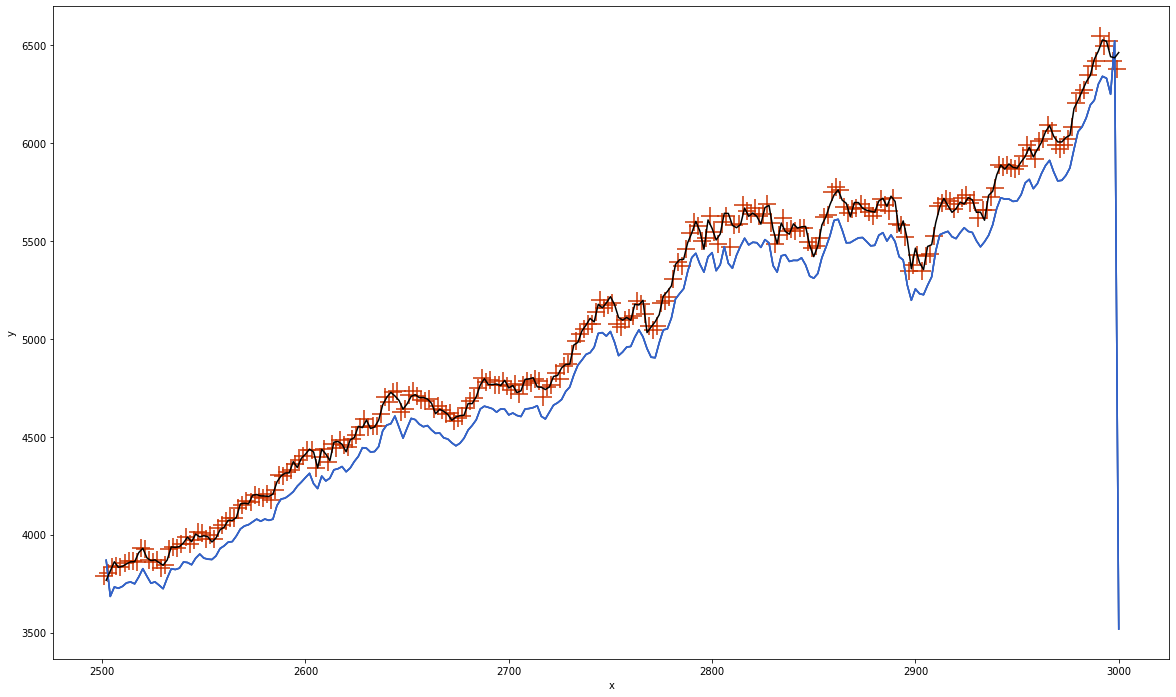

MSE GP:  155.94


In [31]:
plt.figure(figsize=(20,12))
pred_gp_5 = gp_predict(xc_5, yc_5, xt_5, np.transpose([xt_5, yt_5]))
print("MSE GP: {0:7.2f}".format((np.absolute(yt_5 - pred_gp_5[:,1])).mean()))

#### Part 6

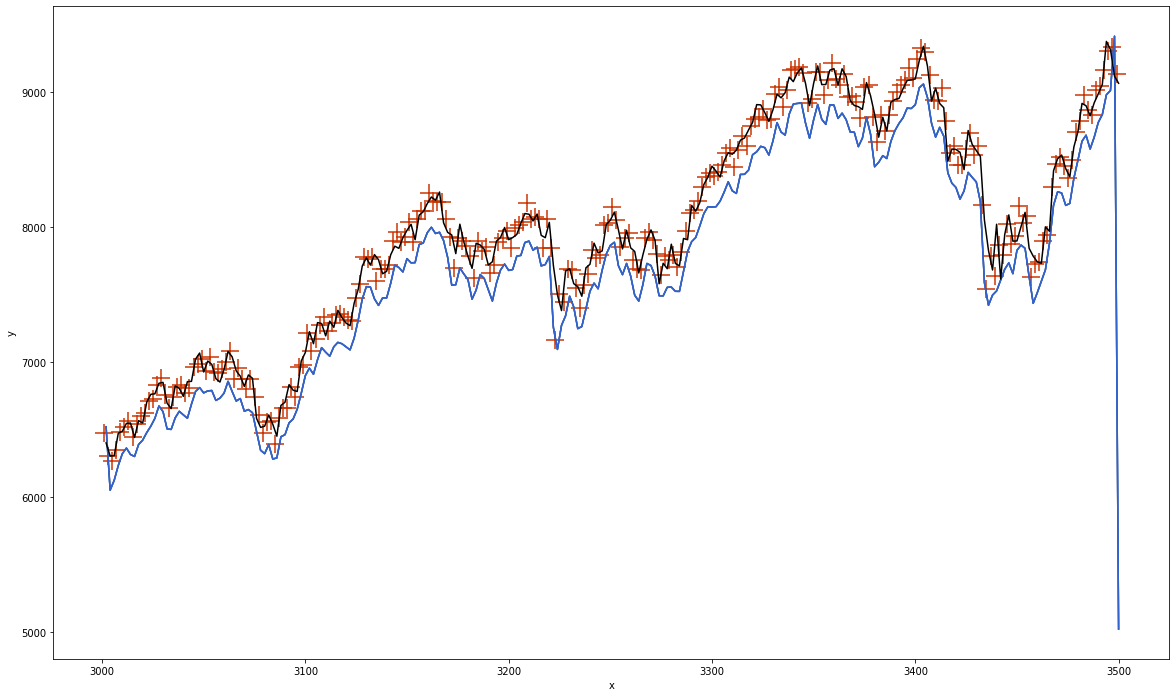

MSE GP:  247.26


In [32]:
plt.figure(figsize=(20,12))
pred_gp_6 = gp_predict(xc_6, yc_6, xt_6, np.transpose([xt_6, yt_6]))
print("MSE GP: {0:7.2f}".format((np.absolute(yt_6 - pred_gp_6[:,1])).mean()))

#### Part 7

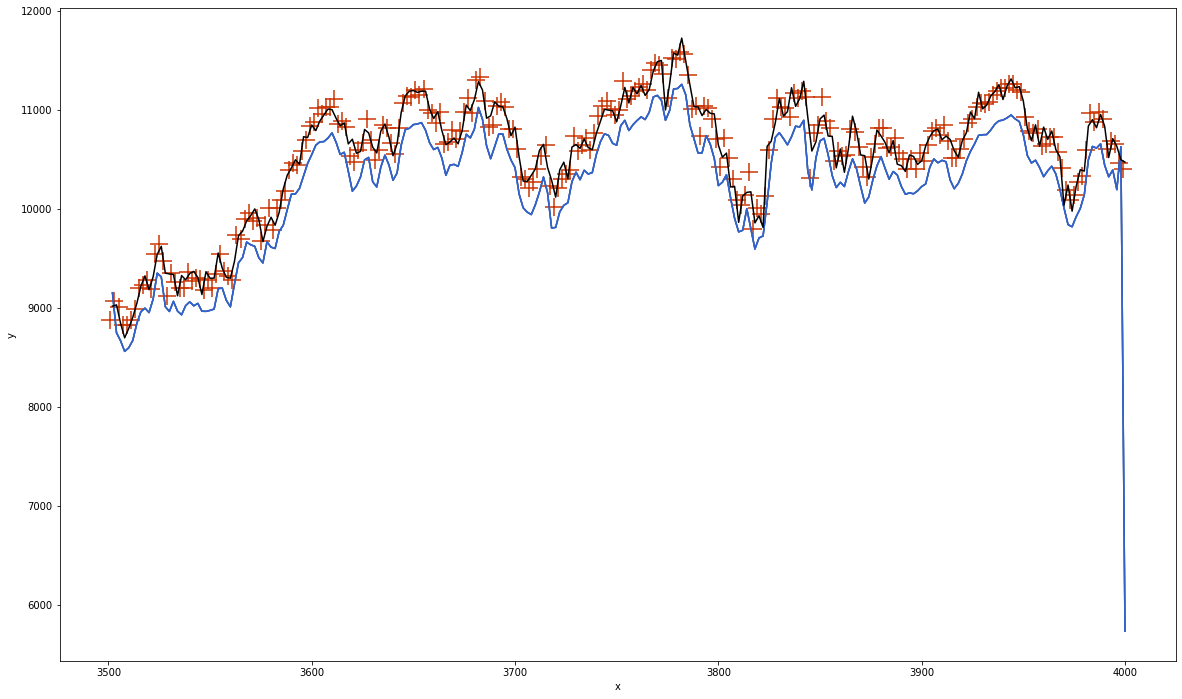

MSE GP:  313.87


In [33]:
plt.figure(figsize=(20,12))
pred_gp_7 = gp_predict(xc_7, yc_7, xt_7, np.transpose([xt_7, yt_7]))
print("MSE GP: {0:7.2f}".format((np.absolute(yt_7 - pred_gp_7[:,1])).mean()))

### - CNP
#### Part 1

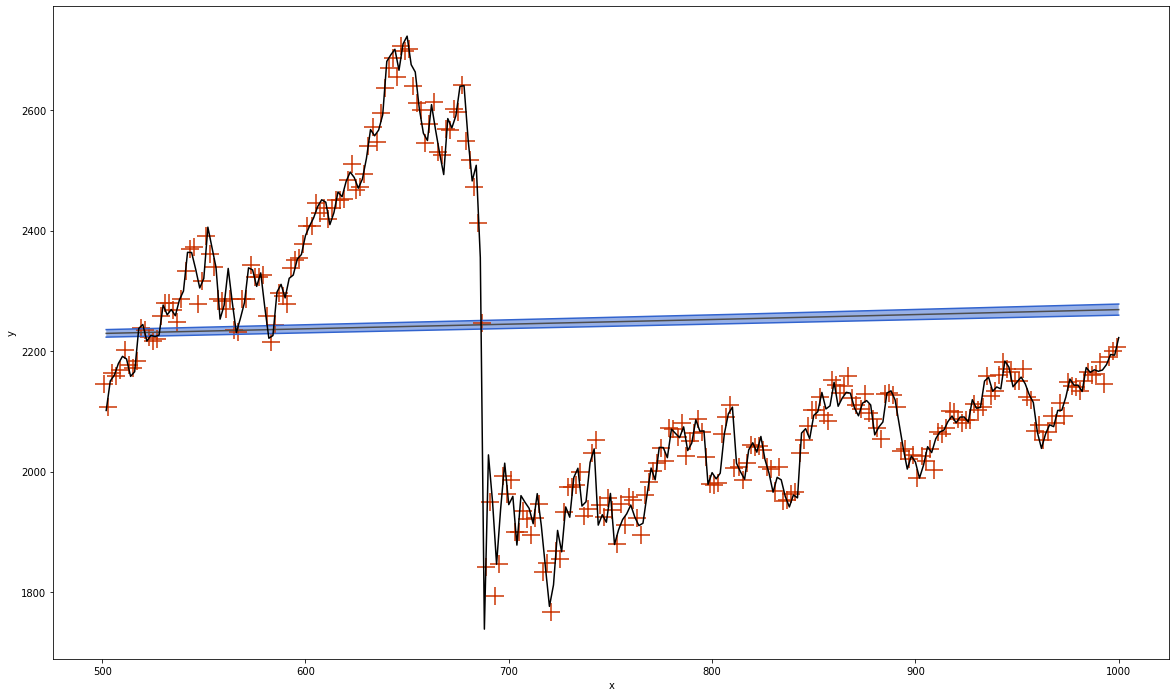

MSE CNP:  201.11


In [34]:
plt.figure(figsize=(20,12))
pred_cnp = cnp_predict(xc, yc, xt, np.transpose([xt, yt]))
print("MSE CNP: {0:7.2f}".format((np.absolute(yt - pred_cnp[:,1])).mean()))

#### Part 2

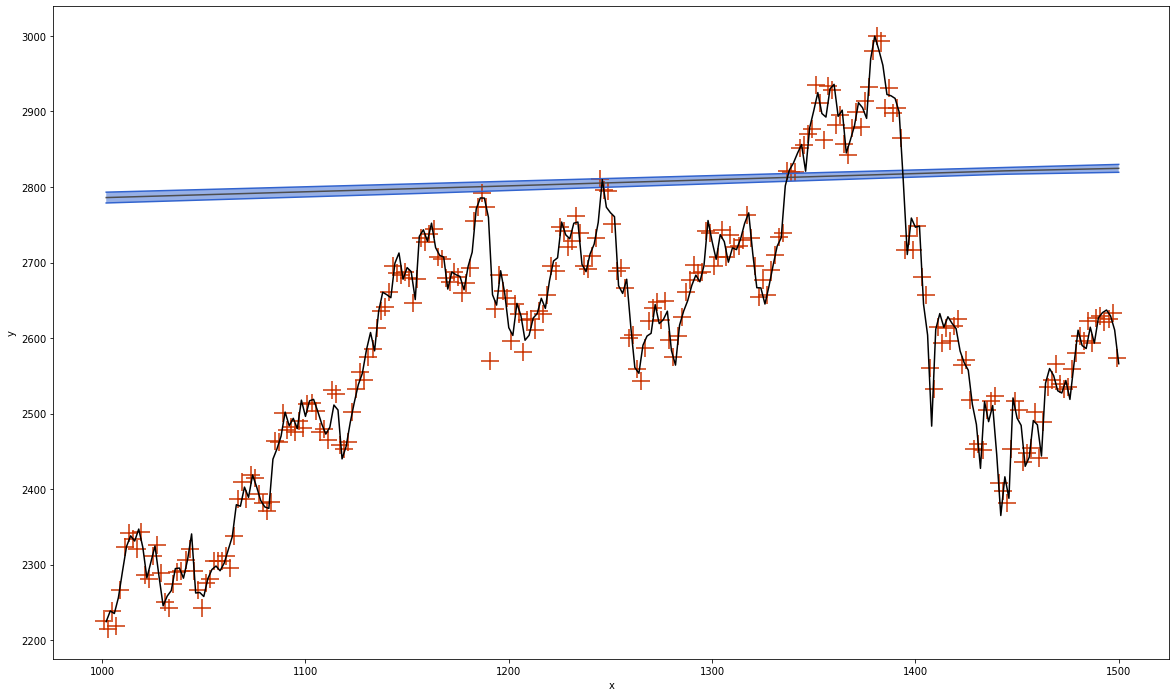

MSE CNP:  221.95


In [35]:
plt.figure(figsize=(20,12))
pred_cnp_2 = cnp_predict(xc_2, yc_2, xt_2, np.transpose([xt_2, yt_2]))
print("MSE CNP: {0:7.2f}".format((np.absolute(yt_2 - pred_cnp_2[:,1])).mean()))

#### Part 3

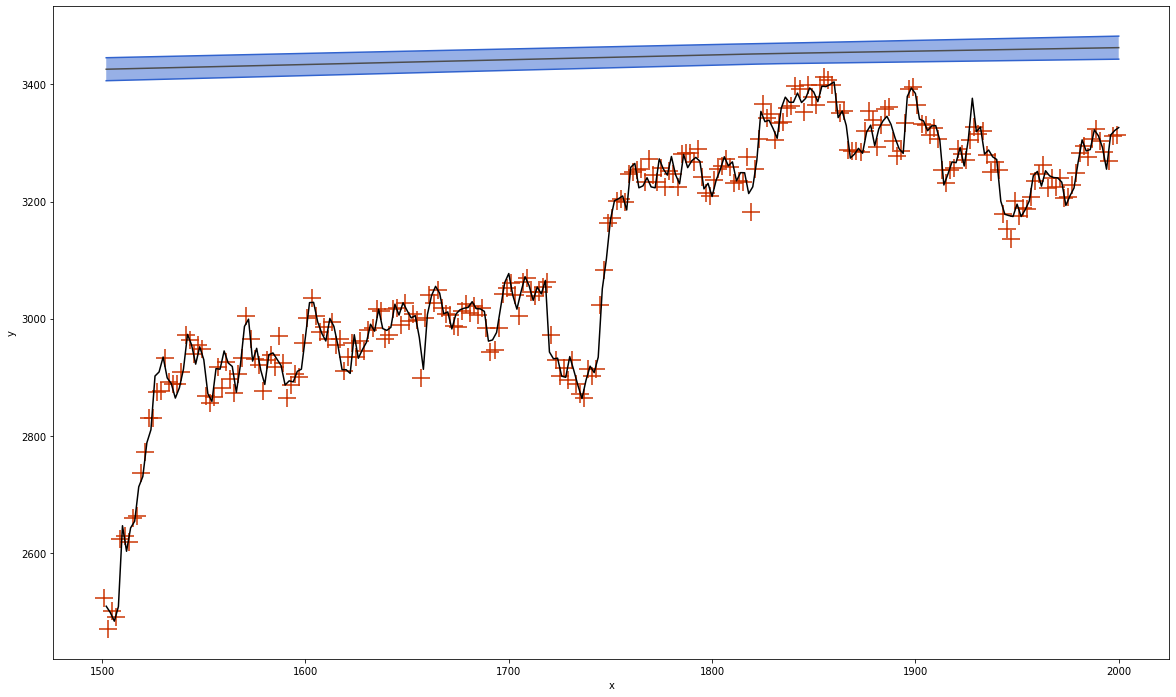

MSE CNP:  335.93


In [36]:
plt.figure(figsize=(20,12))
pred_cnp_3 = cnp_predict(xc_3, yc_3, xt_3, np.transpose([xt_3, yt_3]))
print("MSE CNP: {0:7.2f}".format((np.absolute(yt_3 - pred_cnp_3[:,1])).mean()))

#### Part 4

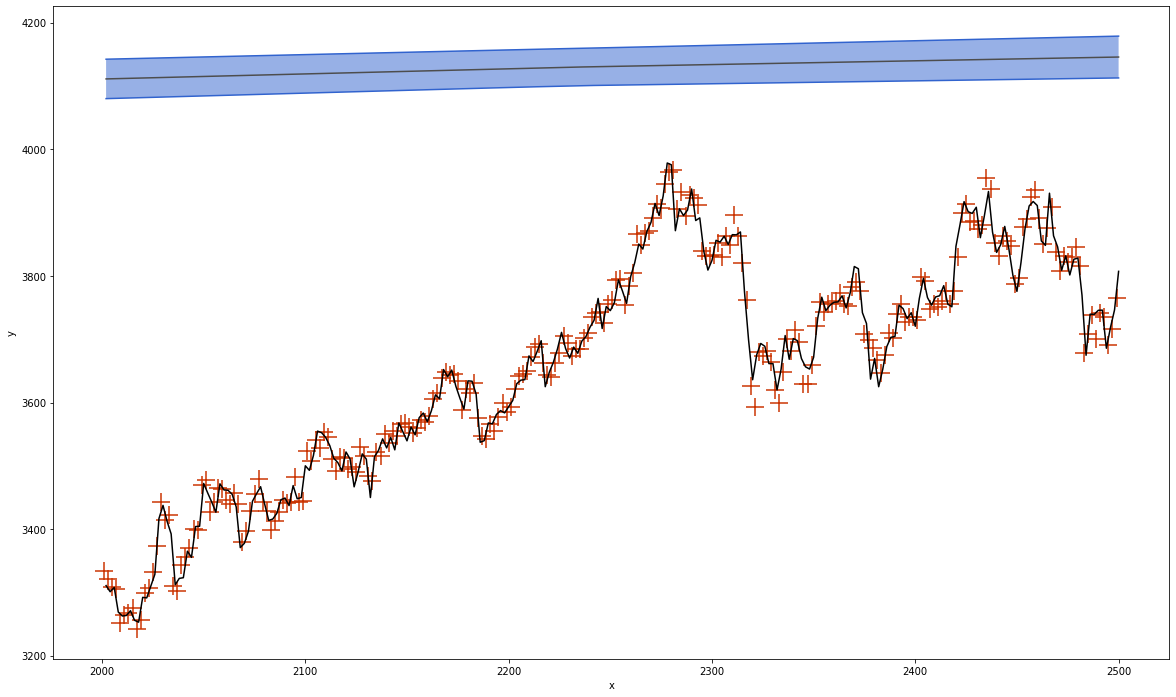

MSE CNP:  476.01


In [37]:
plt.figure(figsize=(20,12))
pred_cnp_4 = cnp_predict(xc_4, yc_4, xt_4, np.transpose([xt_4, yt_4]))
print("MSE CNP: {0:7.2f}".format((np.absolute(yt_4 - pred_cnp_4[:,1])).mean()))

#### Part 5

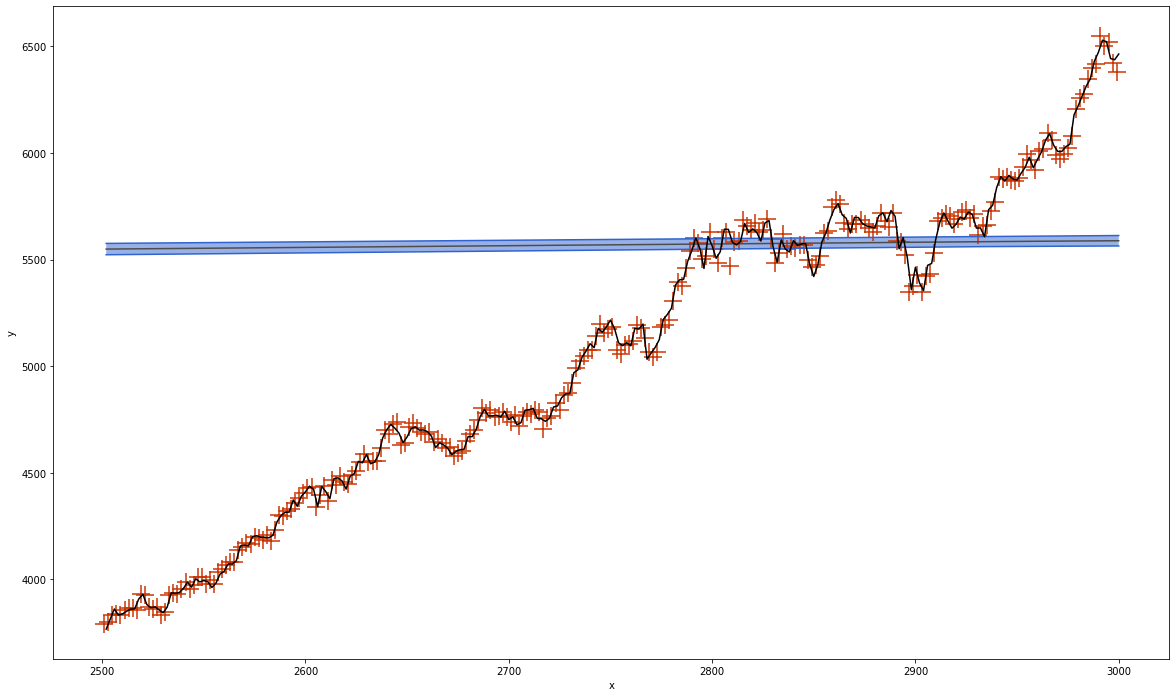

MSE CNP:  676.12


In [38]:
plt.figure(figsize=(20,12))
pred_cnp_5 = cnp_predict(xc_5, yc_5, xt_5, np.transpose([xt_5, yt_5]))
print("MSE CNP: {0:7.2f}".format((np.absolute(yt_5 - pred_cnp_5[:,1])).mean()))

#### Part 6

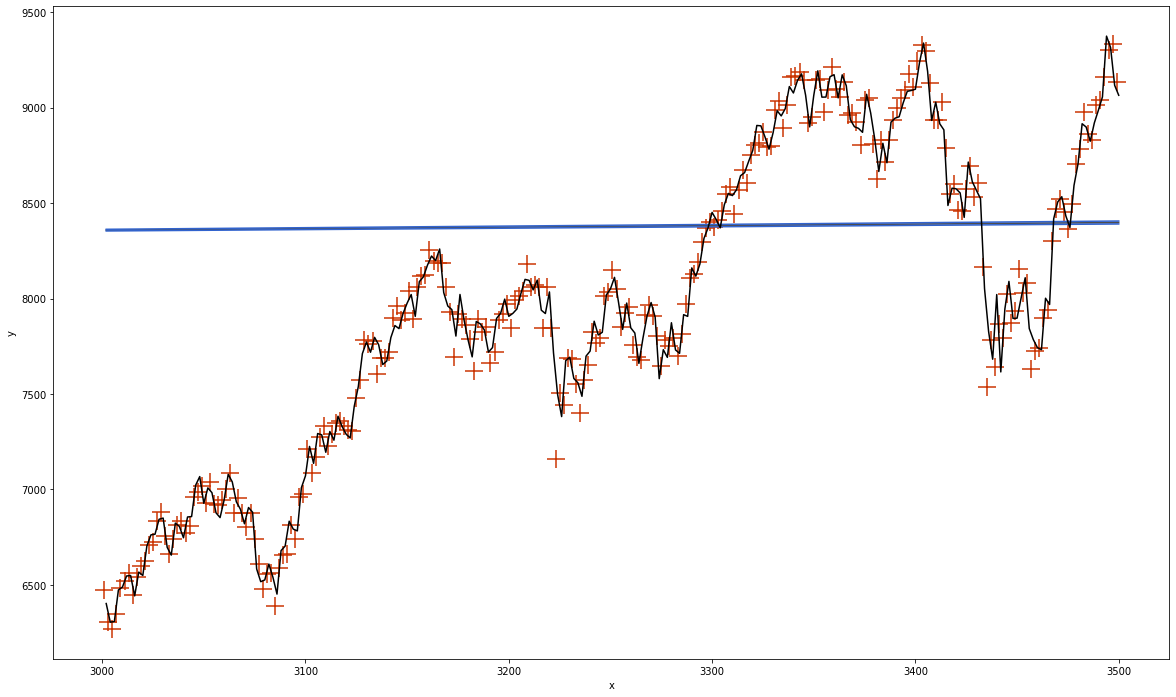

MSE CNP:  739.18


In [39]:
plt.figure(figsize=(20,12))
pred_cnp_6 = cnp_predict(xc_6, yc_6, xt_6, np.transpose([xt_6, yt_6]))
print("MSE CNP: {0:7.2f}".format((np.absolute(yt_6 - pred_cnp_6[:,1])).mean()))

#### Part 7

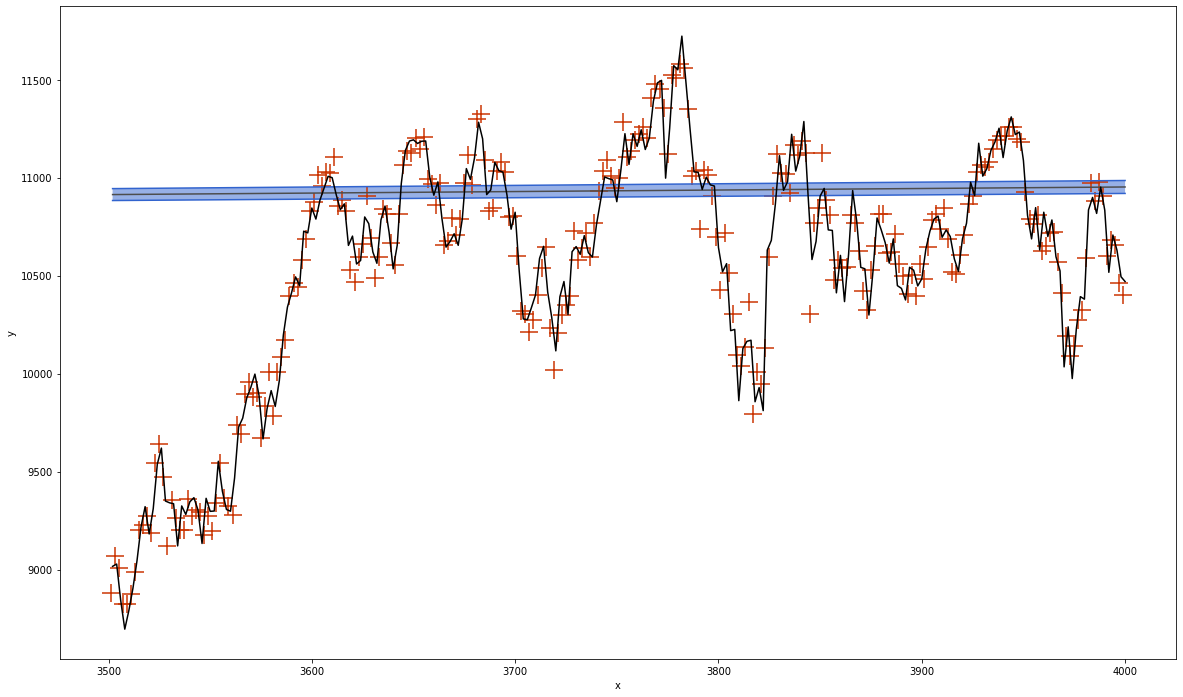

MSE CNP:  505.97


In [40]:
plt.figure(figsize=(20,12))
pred_cnp_7 = cnp_predict(xc_7, yc_7, xt_7, np.transpose([xt_7, yt_7]))
print("MSE CNP: {0:7.2f}".format((np.absolute(yt_7 - pred_cnp_7[:,1])).mean()))

In [41]:
pred_cnp[:,1]

array([2229.3713, 2229.5247, 2229.679 , 2229.8337, 2229.9875, 2230.1418,
       2230.2954, 2230.4495, 2230.6033, 2230.7576, 2230.9126, 2231.0657,
       2231.2195, 2231.3743, 2231.528 , 2231.6814, 2231.836 , 2231.99  ,
       2232.1436, 2232.2976, 2232.4524, 2232.606 , 2232.7595, 2232.9143,
       2233.068 , 2233.2224, 2233.3757, 2233.53  , 2233.6853, 2233.8386,
       2233.9924, 2234.1462, 2234.2996, 2234.4548, 2234.6084, 2234.763 ,
       2234.9172, 2235.07  , 2235.2249, 2235.3787, 2235.5325, 2235.687 ,
       2235.84  , 2235.9944, 2236.1492, 2236.3035, 2236.4563, 2236.6108,
       2236.7646, 2236.9192, 2237.0723, 2237.2278, 2237.3806, 2237.5354,
       2237.6892, 2237.8433, 2237.9985, 2238.151 , 2238.3054, 2238.4597,
       2238.613 , 2238.7673, 2238.9216, 2239.075 , 2239.2297, 2239.3835,
       2239.5374, 2239.6917, 2239.8457, 2239.9998, 2240.1536, 2240.3083,
       2240.462 , 2240.6155, 2240.7695, 2240.9236, 2241.0784, 2241.2322,
       2241.3855, 2241.5393, 2241.694 , 2241.8481, 